## 0. Imports

In [1]:
import pandas as pd
import numpy as np

from IPython.core.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
## Settings
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

## 1. Data preparation

### 1.1 Import the data


In [3]:
df = pd.read_csv('telco_churn.csv')

### 1.2 Format column names and values


In [4]:
df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for column in categorical_columns:
    df[column] = df[column].str.lower().replace(' ','_')

In [5]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)

### 1.3 Check if the churn variable needs any preapration


In [6]:
df.churn = df.churn.map({'yes':1, 'no':0})

## 2. Validation Framework

### 2.1 Split data into train and test data


In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

### 2.2 Split train data into train and validation data


In [8]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

### 2.3 Check datasets lengths


In [10]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

### 2.4 Separate features from target variable


In [11]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [12]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

## 3. Exploratory Data Analysis

### 3.1 Check missing values

In [13]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

### 3.2 Look at target variable (churn)


In [14]:
df_full_train.churn.value_counts(normalize=True)

0   0.73
1   0.27
Name: churn, dtype: float64

In [15]:
global_churn_rate = df_full_train.churn.mean()
global_churn_rate.round(2)

0.27

### 3.3 Look at numerical anda categorical variables


In [16]:
df_full_train.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object

In [17]:
df_full_train.seniorcitizen = df_full_train.seniorcitizen.map({1:'yes',0:'no'})

In [18]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [x for x in list(df_full_train.columns) if x not in numerical][1:-1]

In [19]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

### 3.4 Feature Importance

In [20]:
def groupby_churn(df, column):
    churn = df_full_train[[column,'churn']].groupby(column).mean().reset_index()
    #churn['difference'] = churn.churn.apply(lambda x: global_churn_rate - x)
    churn['risk_ratio'] = churn.churn.apply(lambda x: x/global_churn_rate)
    return churn

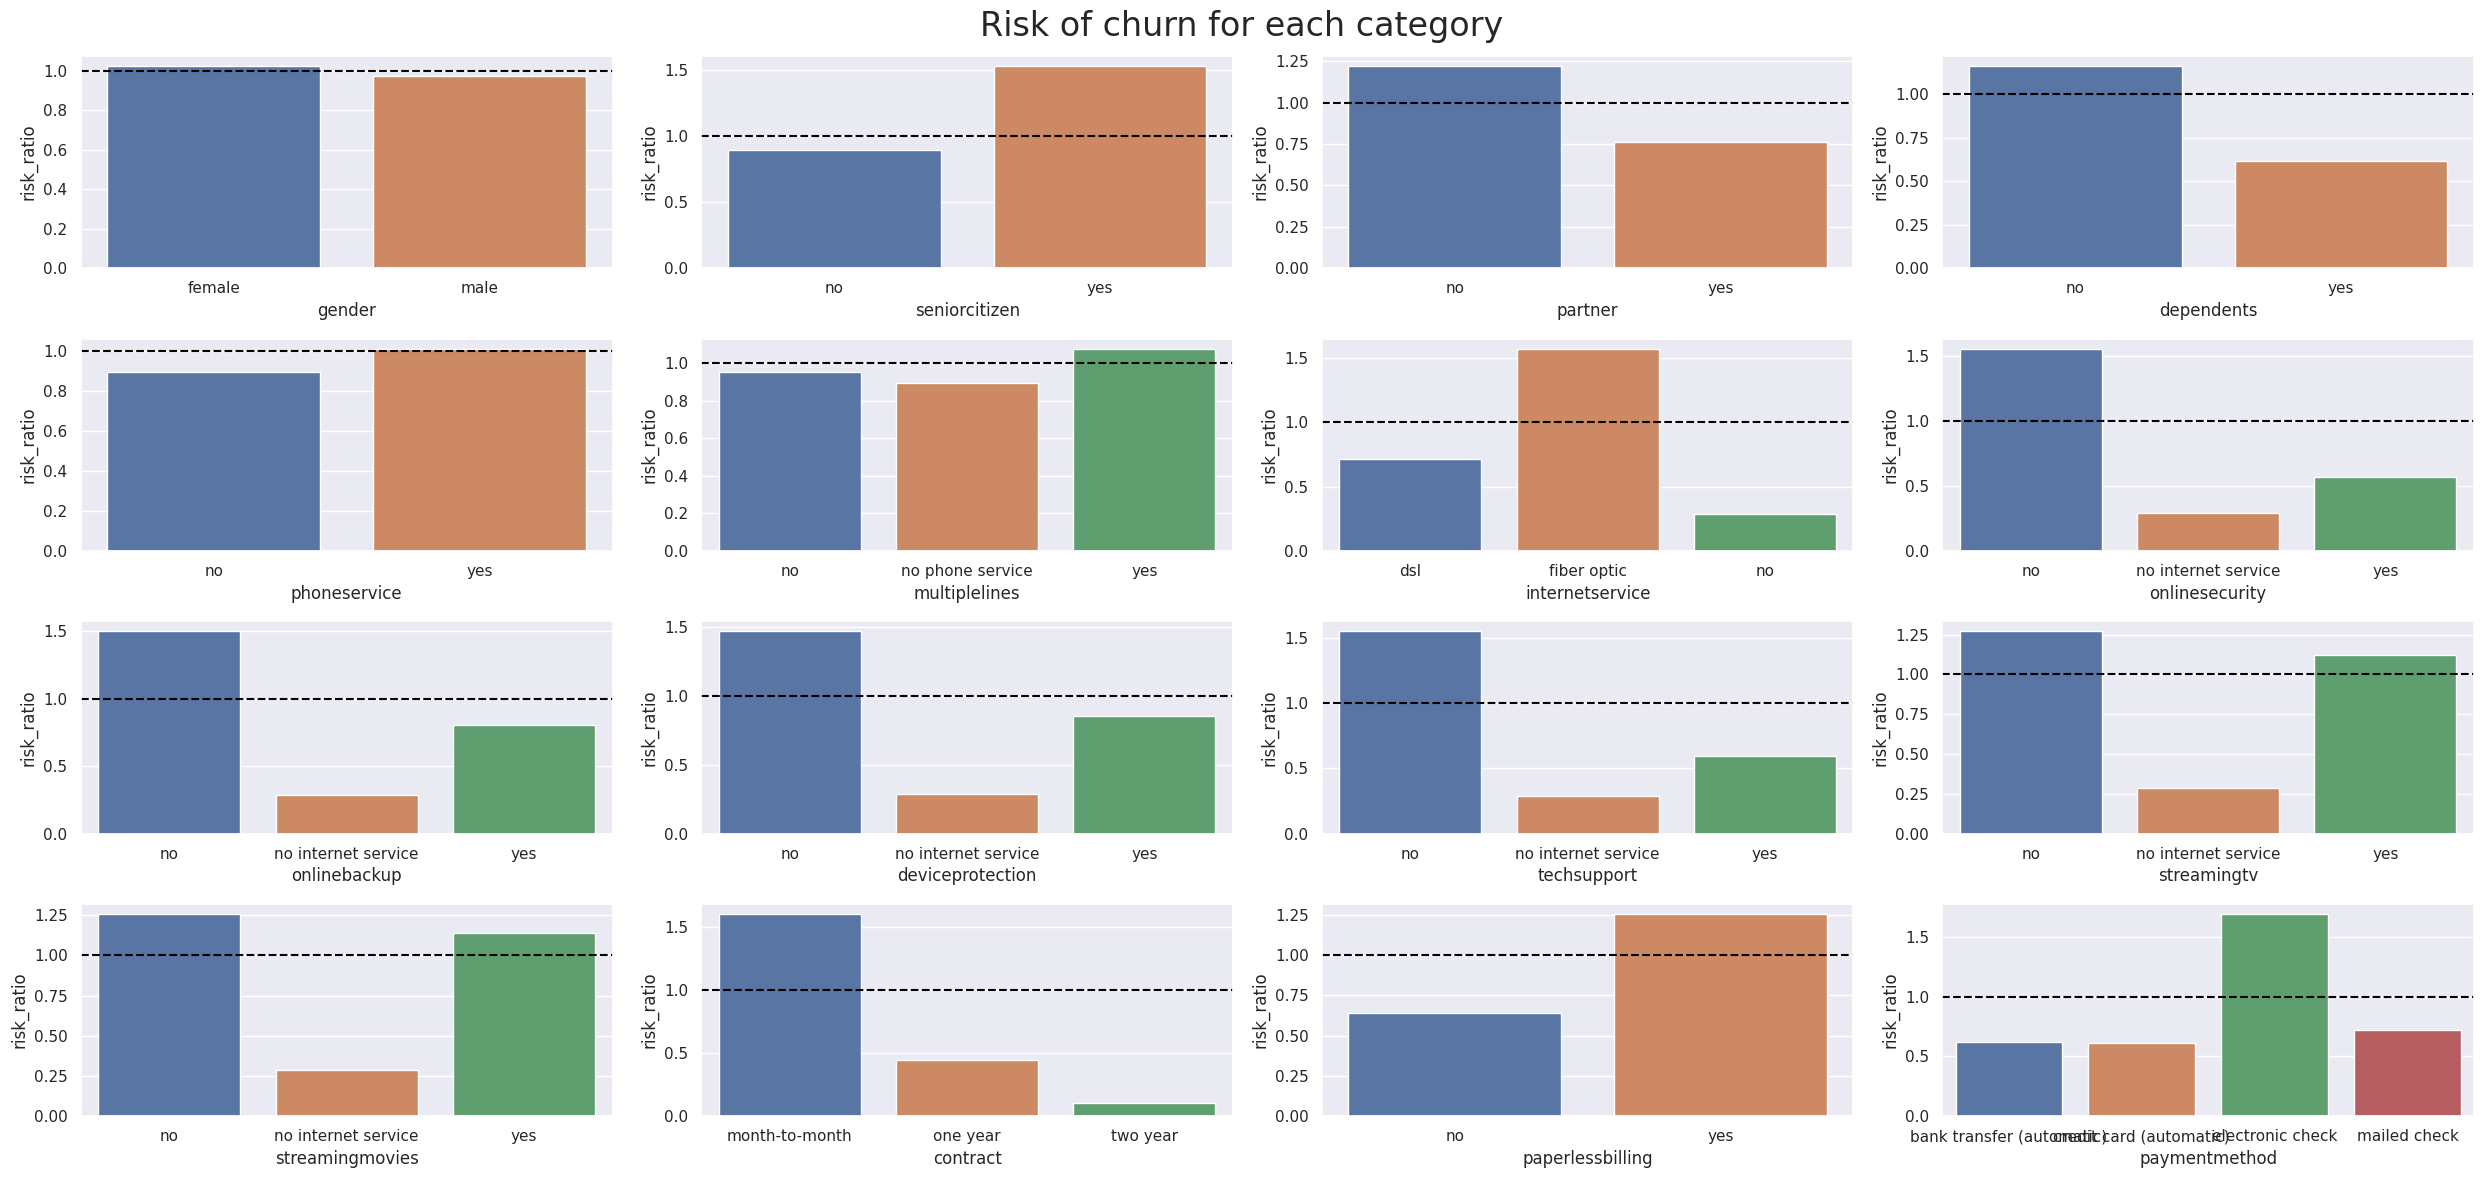

In [21]:
for index,column in enumerate(categorical):
    df_gb = groupby_churn(df_full_train, column)
    plt.subplot(4,4,index+1)
    sns.barplot(data=df_gb, x=column, y='risk_ratio')
    plt.axhline(1, linestyle='--', color='0')
plt.suptitle('Risk of churn for each category', fontsize=24)
plt.tight_layout()
plt.show()

- Mutual information (importance of categorical variables)

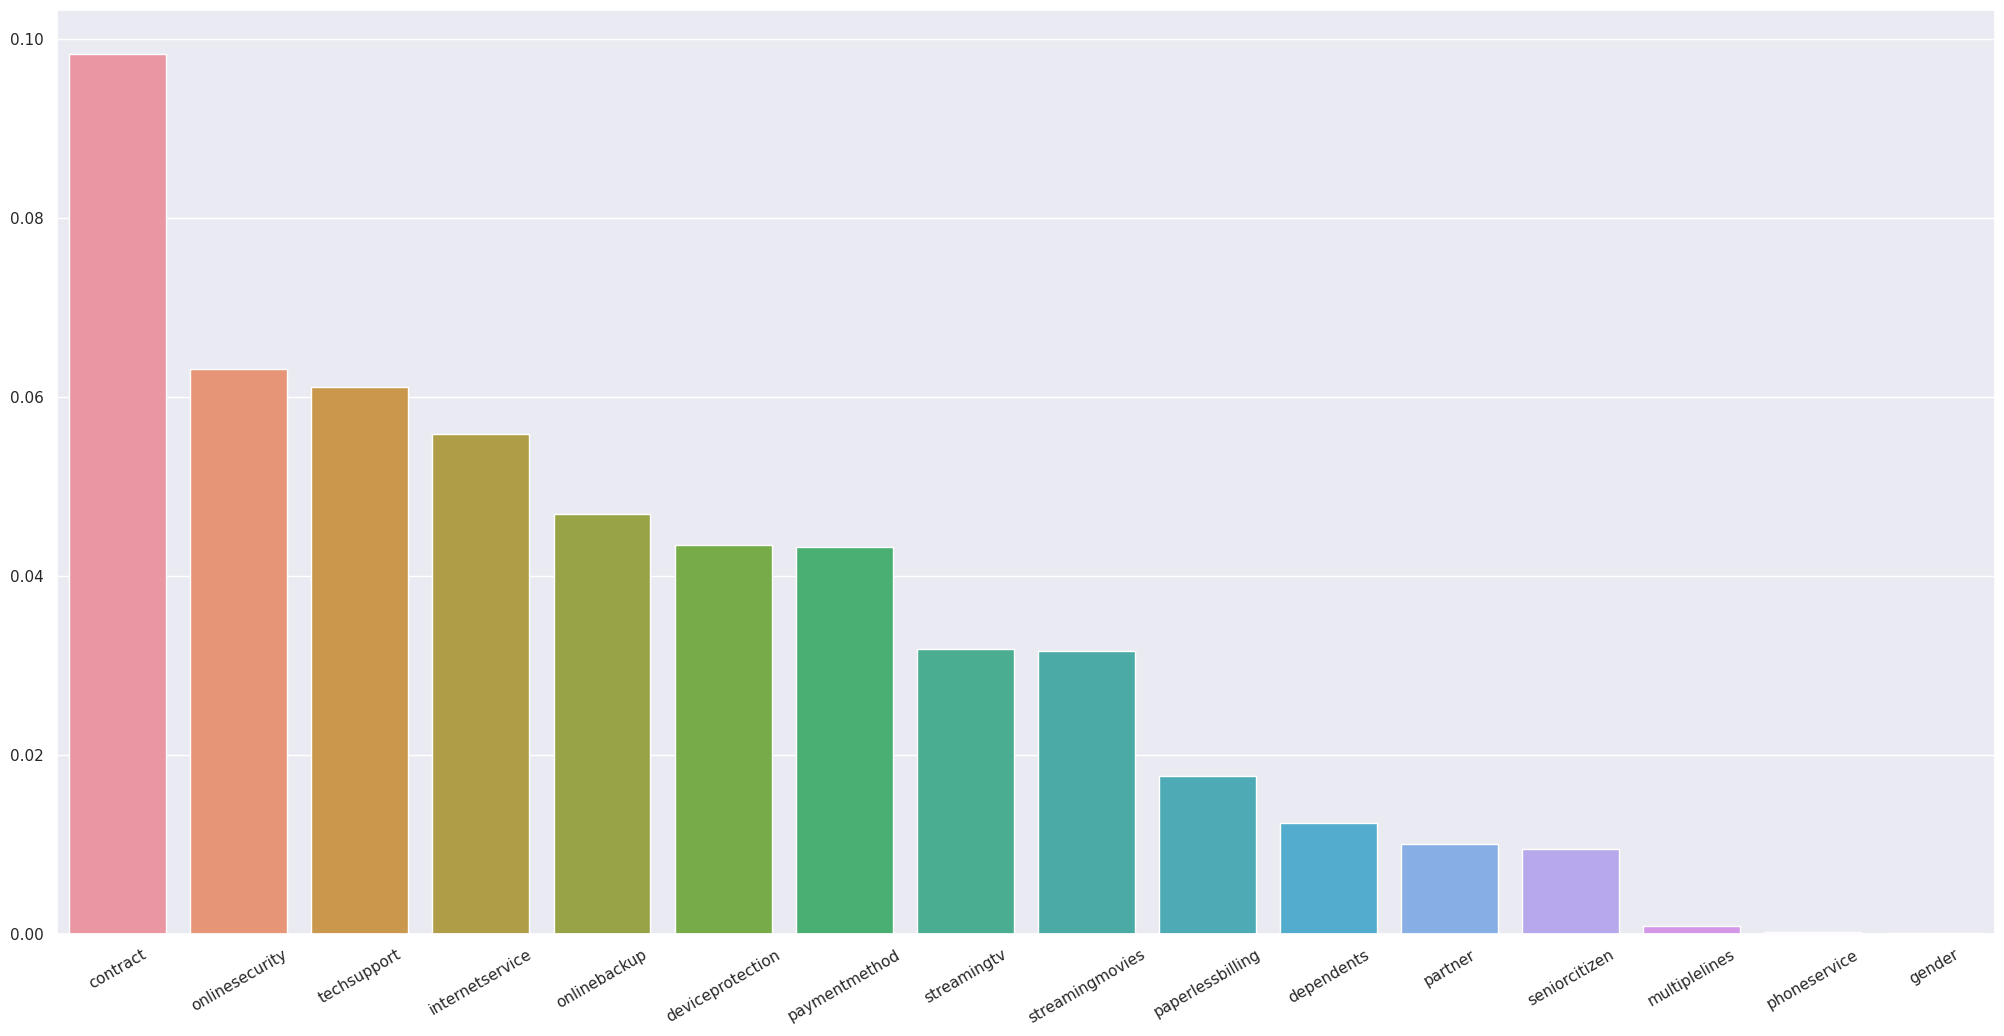

In [22]:
mutual_info = {}
for column in categorical:
    score = mutual_info_score(df_full_train.churn, df_full_train[column])
    mutual_info[column] = score
df_mutual = pd.Series(mutual_info).sort_values(ascending=False)
sns.barplot(x=df_mutual.index, y=df_mutual.values)
plt.xticks(rotation=30)
plt.show()

- Correlation ('Pearson' - importance of numerical variables)


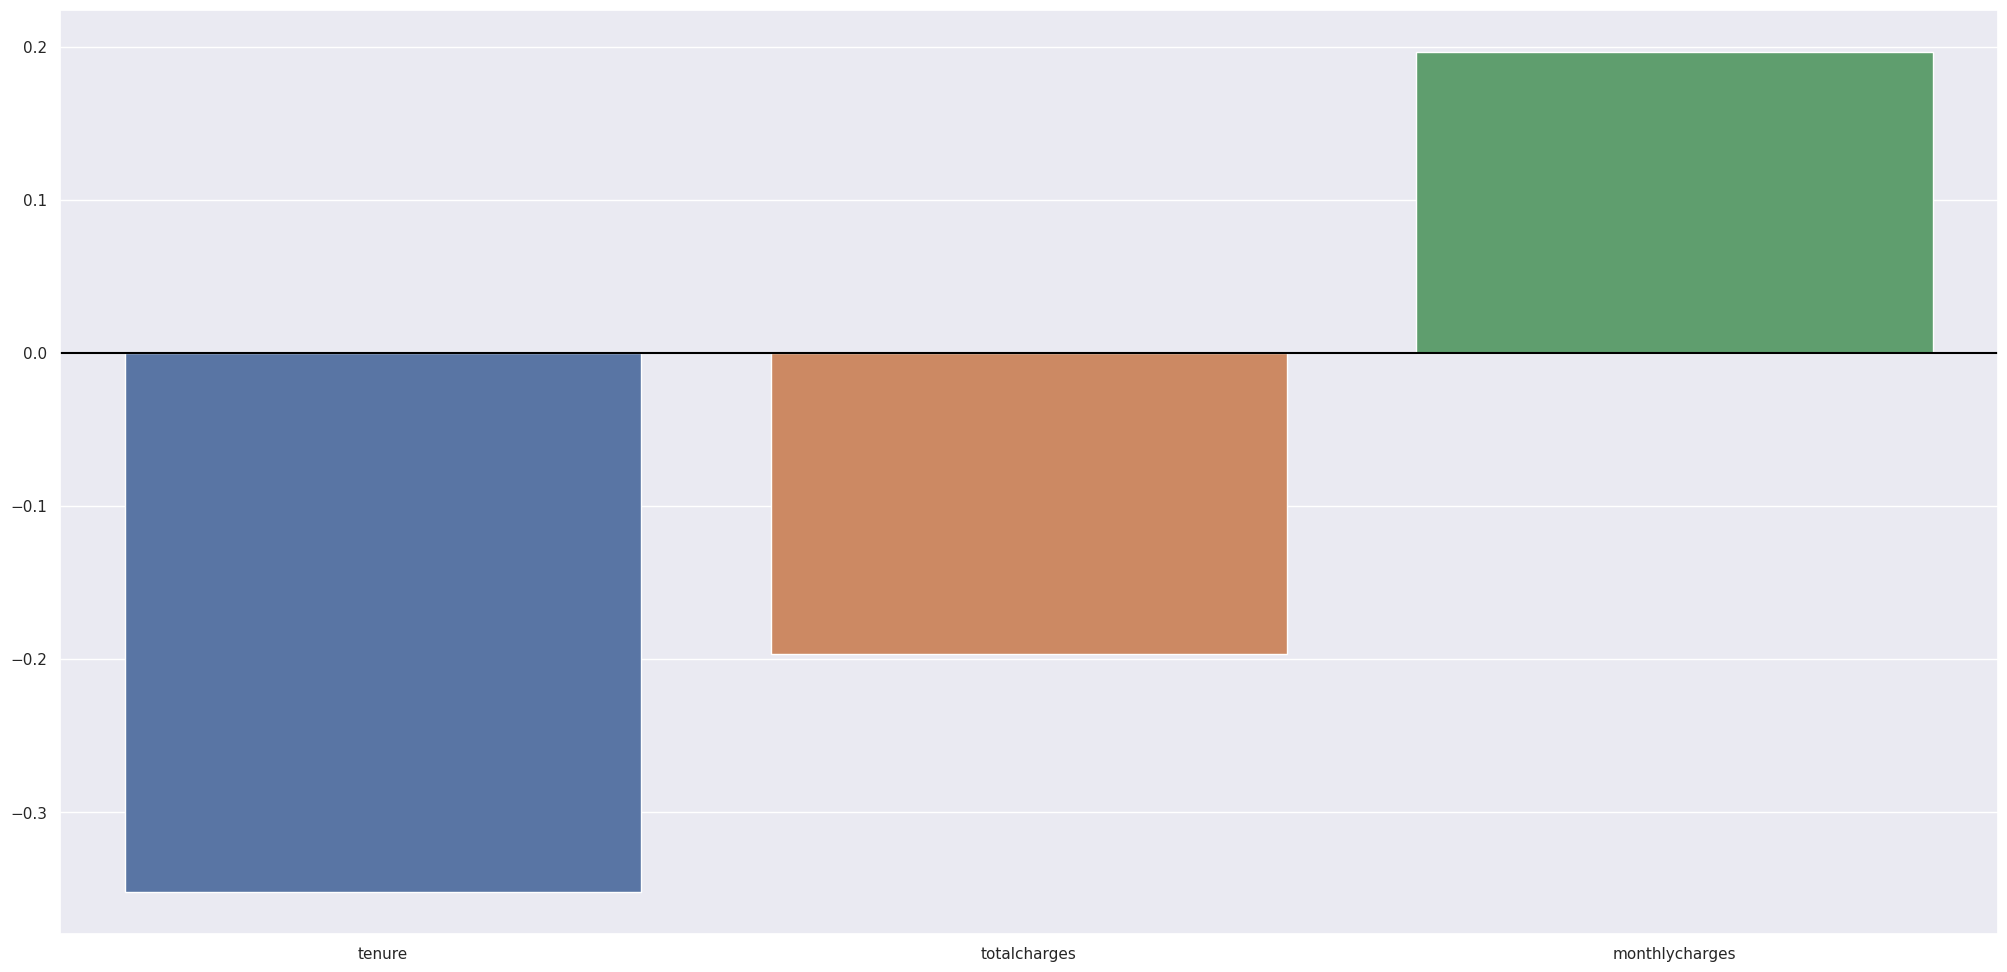

In [23]:
corr = df_full_train[numerical].corrwith(df_full_train.churn).sort_values()
sns.barplot(x=corr.index, y=corr.values)
plt.axhline(0, linestyle='-', color='0')
plt.show()

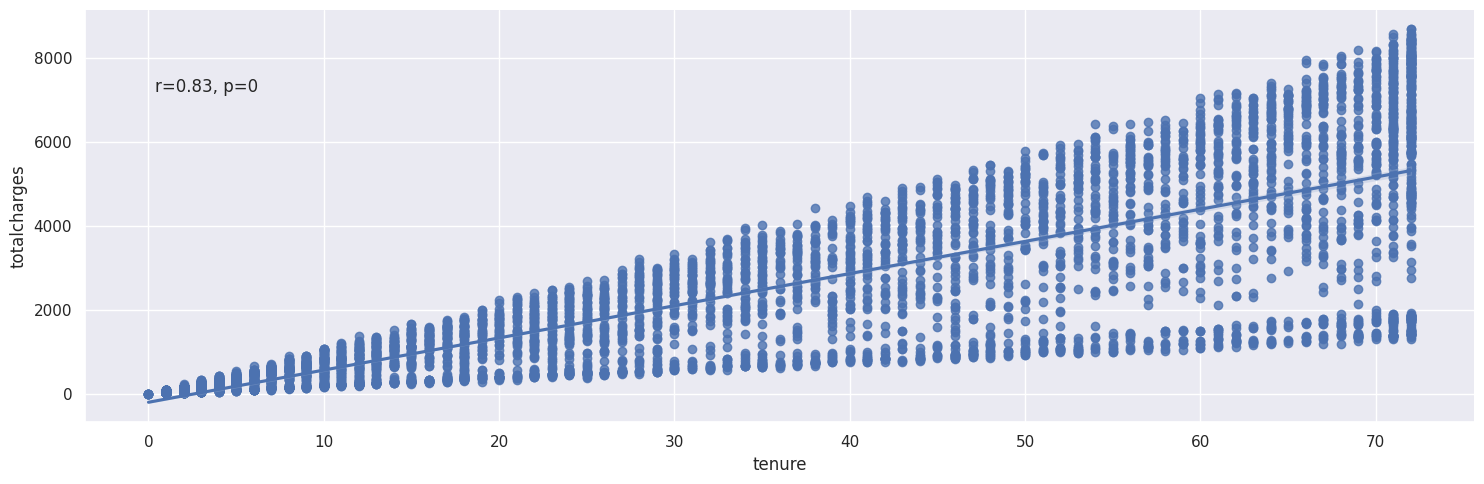

PearsonRResult(statistic=0.8282676242194342, pvalue=0.0)

In [24]:
import scipy as sp
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(df_full_train.tenure.values, df_full_train.totalcharges.values)
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

g = sns.lmplot(data=df_full_train, x='tenure', y='totalcharges', aspect=3)
g.map_dataframe(annotate)
plt.show()

sp.stats.pearsonr(df_full_train.tenure.values, df_full_train.totalcharges.values)

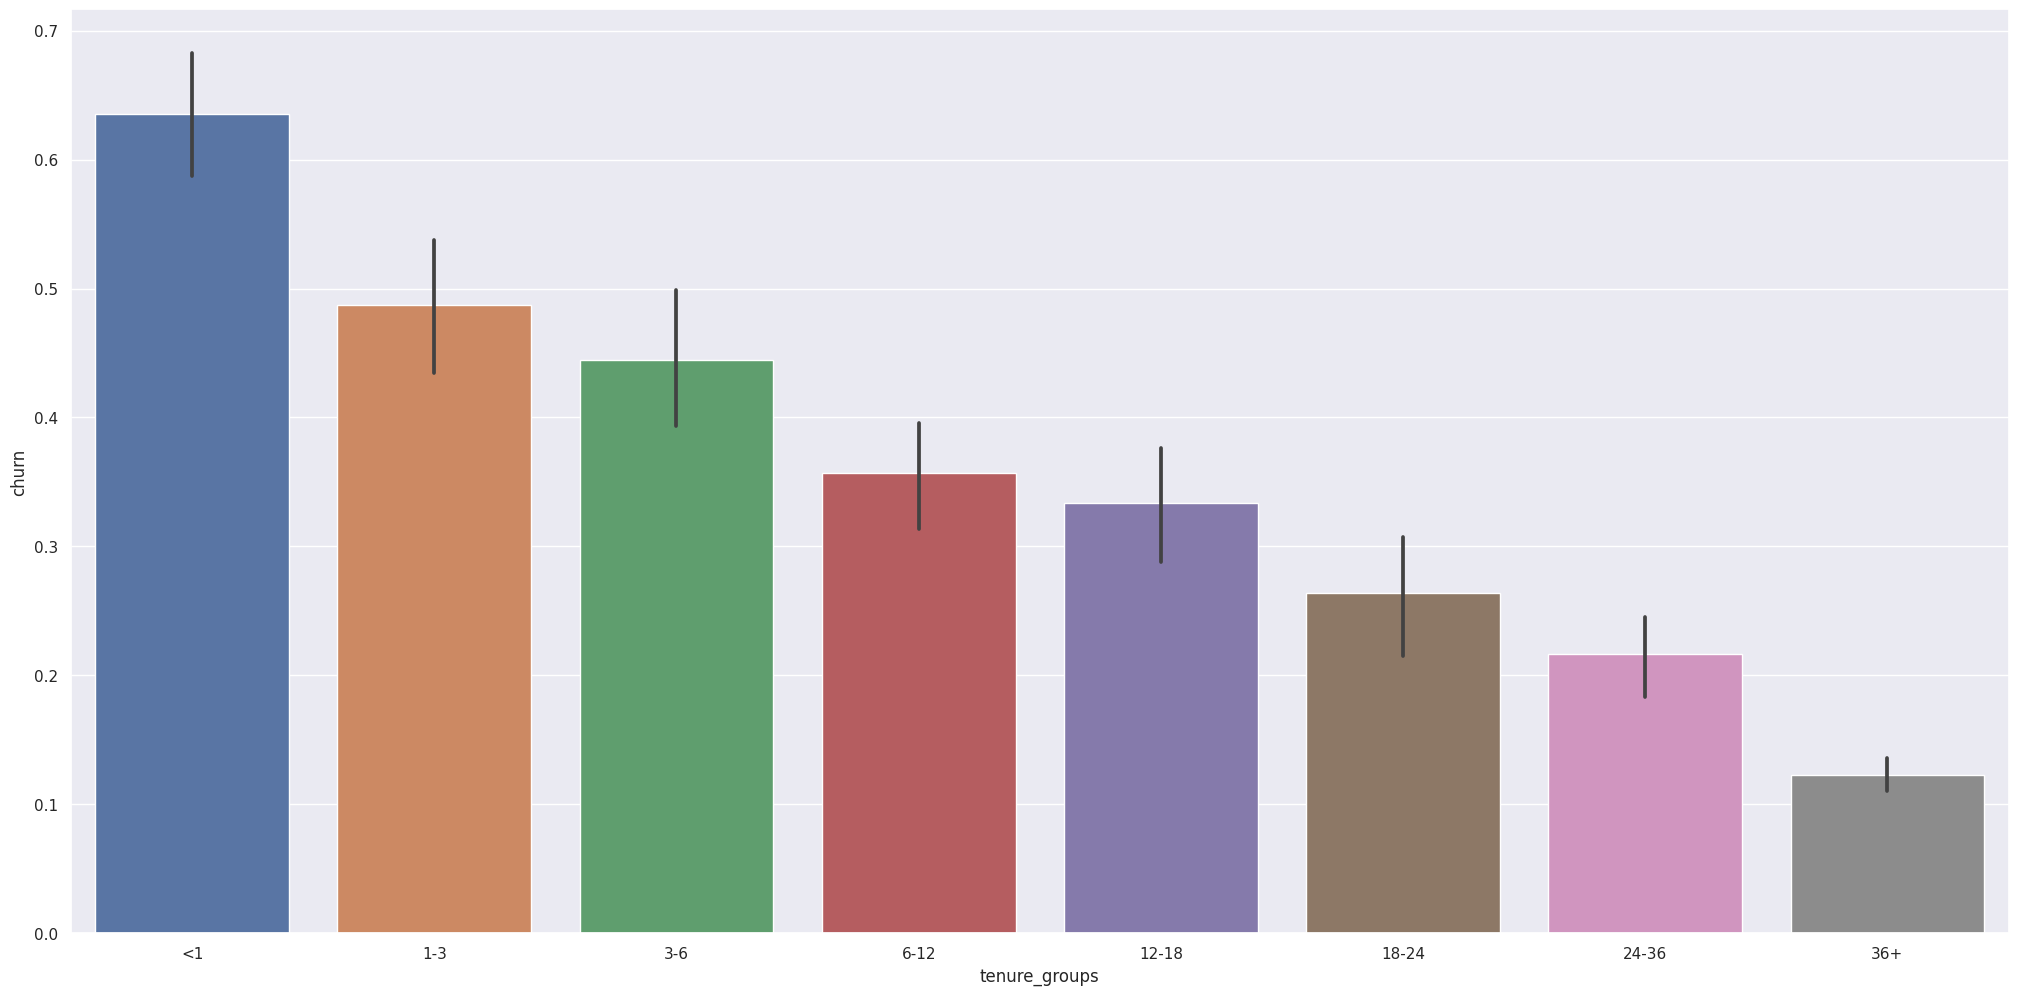

In [25]:
bins = [0, 1, 3, 6, 12, 18, 24, 36, np.inf]
names = ['<1', '1-3', '3-6', '6-12', '12-18', '18-24', '24-36', '36+']

df_full_train['tenure_groups'] = pd.cut(df_full_train.tenure, bins, labels=names)
sns.barplot(data=df_full_train, x='tenure_groups', y='churn');

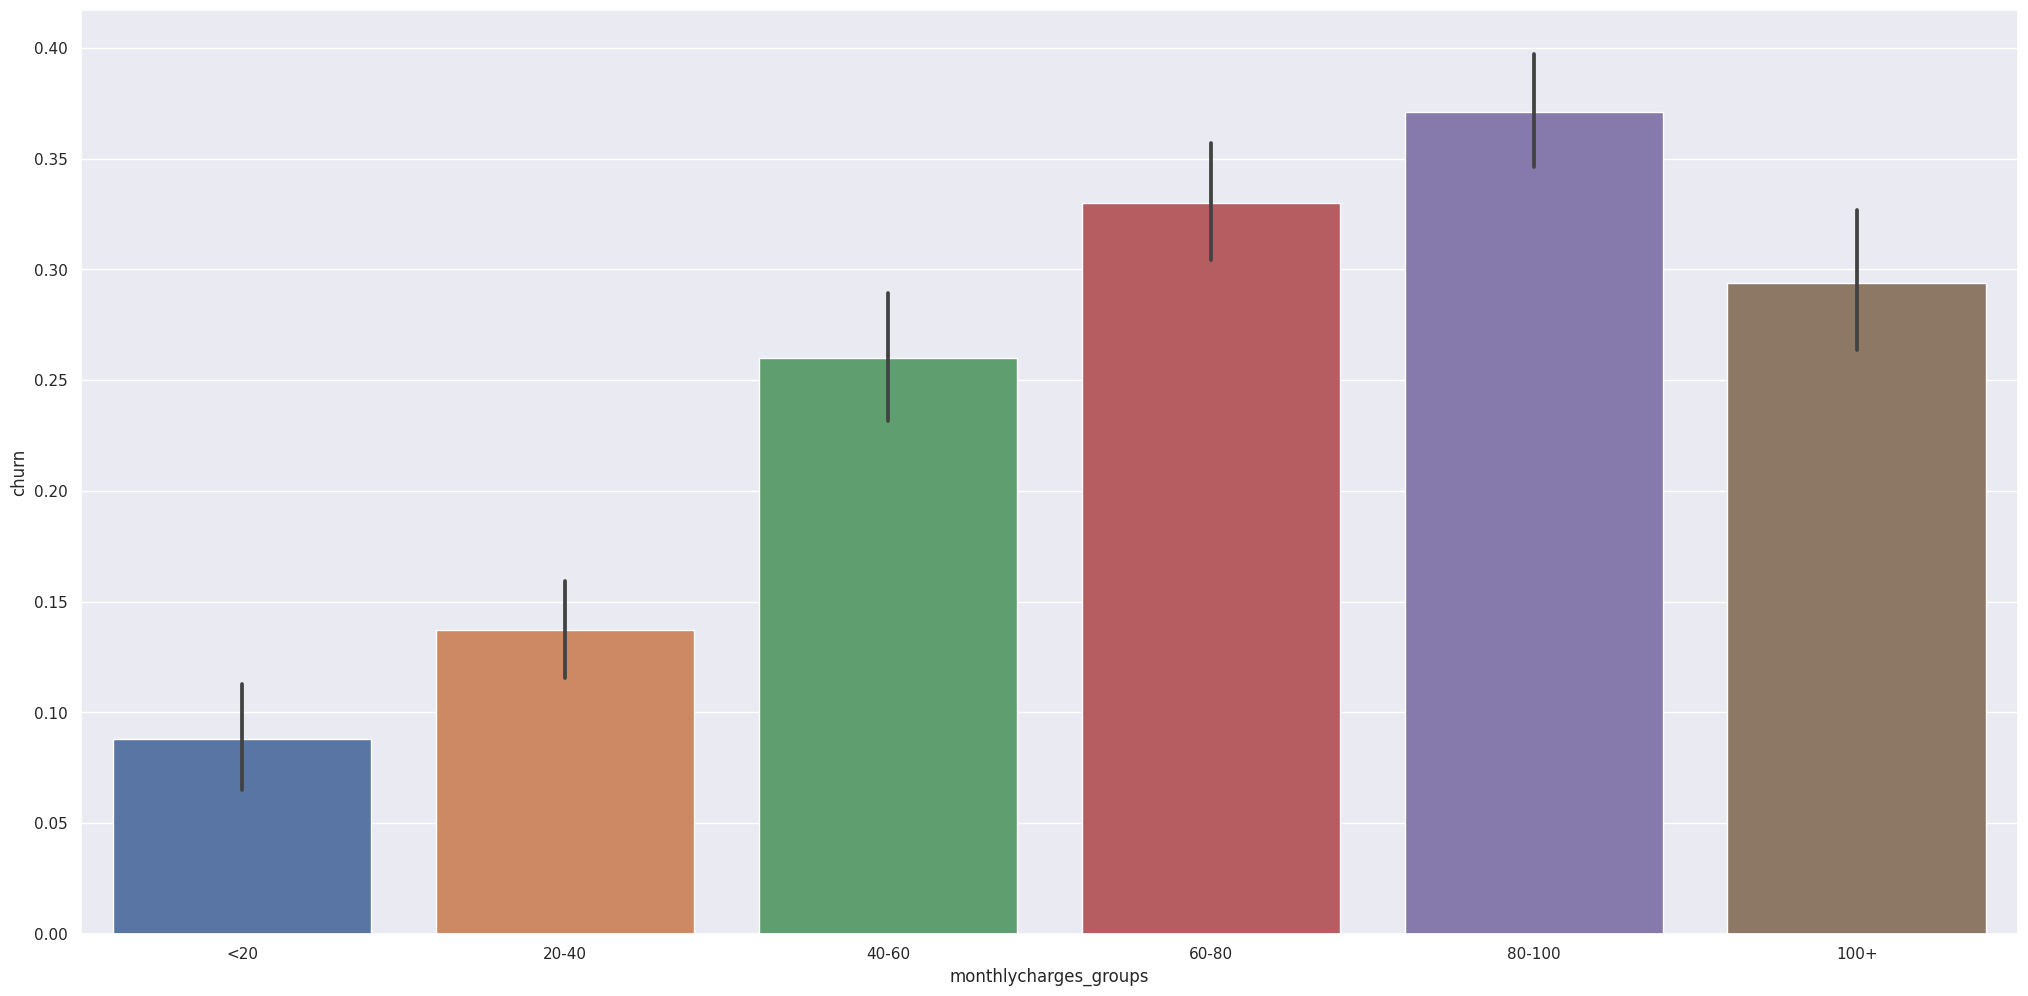

In [26]:
bins = [0, 20, 40, 60, 80, 100, np.inf]
names = ['<20', '20-40', '40-60', '60-80', '80-100', '100+']

df_full_train['monthlycharges_groups'] = pd.cut(df_full_train.monthlycharges, bins, labels=names)
sns.barplot(data=df_full_train, x='monthlycharges_groups', y='churn');

## 4. Variable encoding (One-Hot Encoding)

In [27]:
dv = DictVectorizer(sparse=False)

- Training data

In [28]:
train_dicts = df_train[categorical+numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)

- Validation data

In [29]:
val_dicts = df_val[categorical+numerical].to_dict(orient='records')

X_val = dv.transform(val_dicts)

## 5. Train model (Logistic Regression)

In [30]:
model = LogisticRegression()
model.fit(X_train, y_train);

In [31]:
y_pred = model.predict_proba(X_val)[:,1]

threshold = 0.50
churn_decision = (y_pred >= threshold)

In [32]:
evaluation = accuracy_score(y_val, churn_decision)
evaluation

0.8034066713981547

## 6. Model interpretation

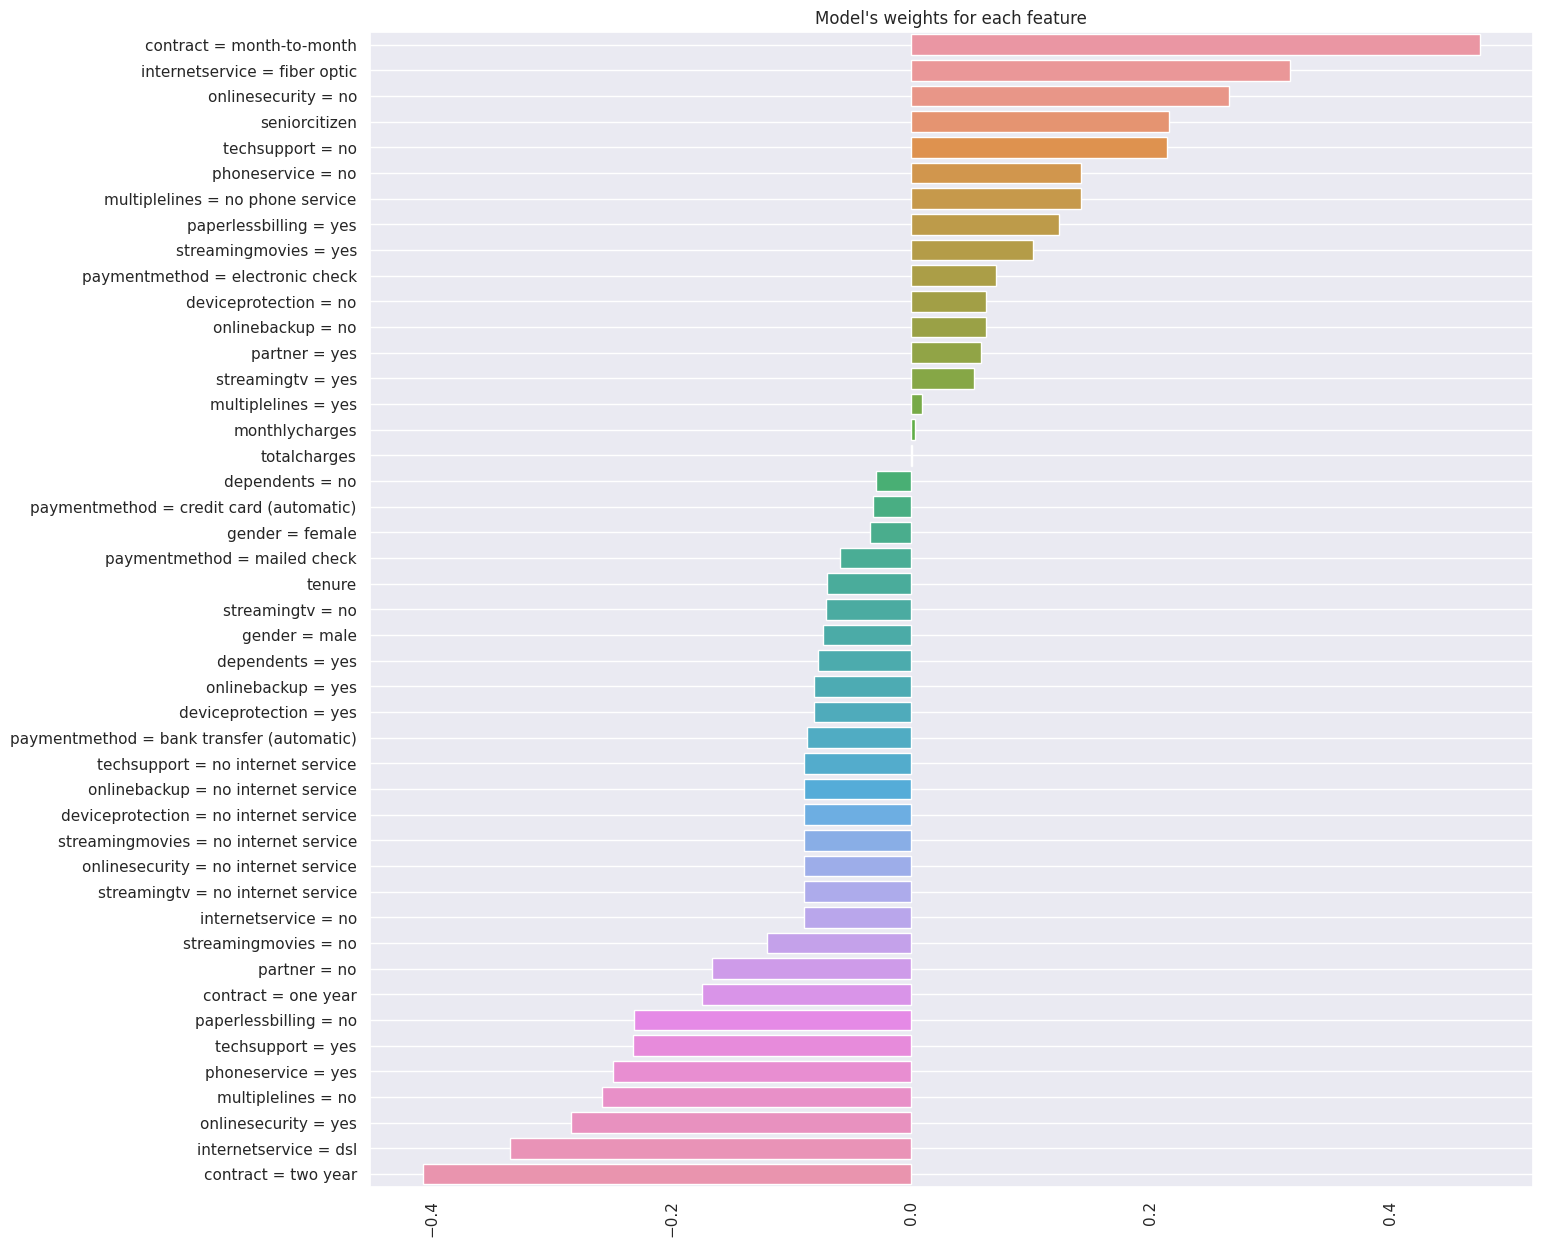

In [33]:
weights = pd.Series(dict(zip(dv.get_feature_names_out(), model.coef_[0]))).sort_values(ascending=False)
weights.index = [x.replace('=',' = ') for x in list(weights.index)]

plt.figure(figsize=(15,15))
plt.title("Model's weights for each feature")
sns.barplot(y=weights.index, x=weights.values)
plt.xticks(rotation=90)
ax = plt.gca()
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines
plt.show()

- Trying smaller model

In [34]:
small = ['contract', 'tenure','monthlycharges']
small_dicts_train = df_train[small].to_dict(orient='records')
small_dicts_val = df_val[small].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)
dv_small.fit(small_dicts_train)

X_train_small = dv_small.transform(small_dicts_train)
X_val_small = dv_small.transform(small_dicts_val)

In [35]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train);

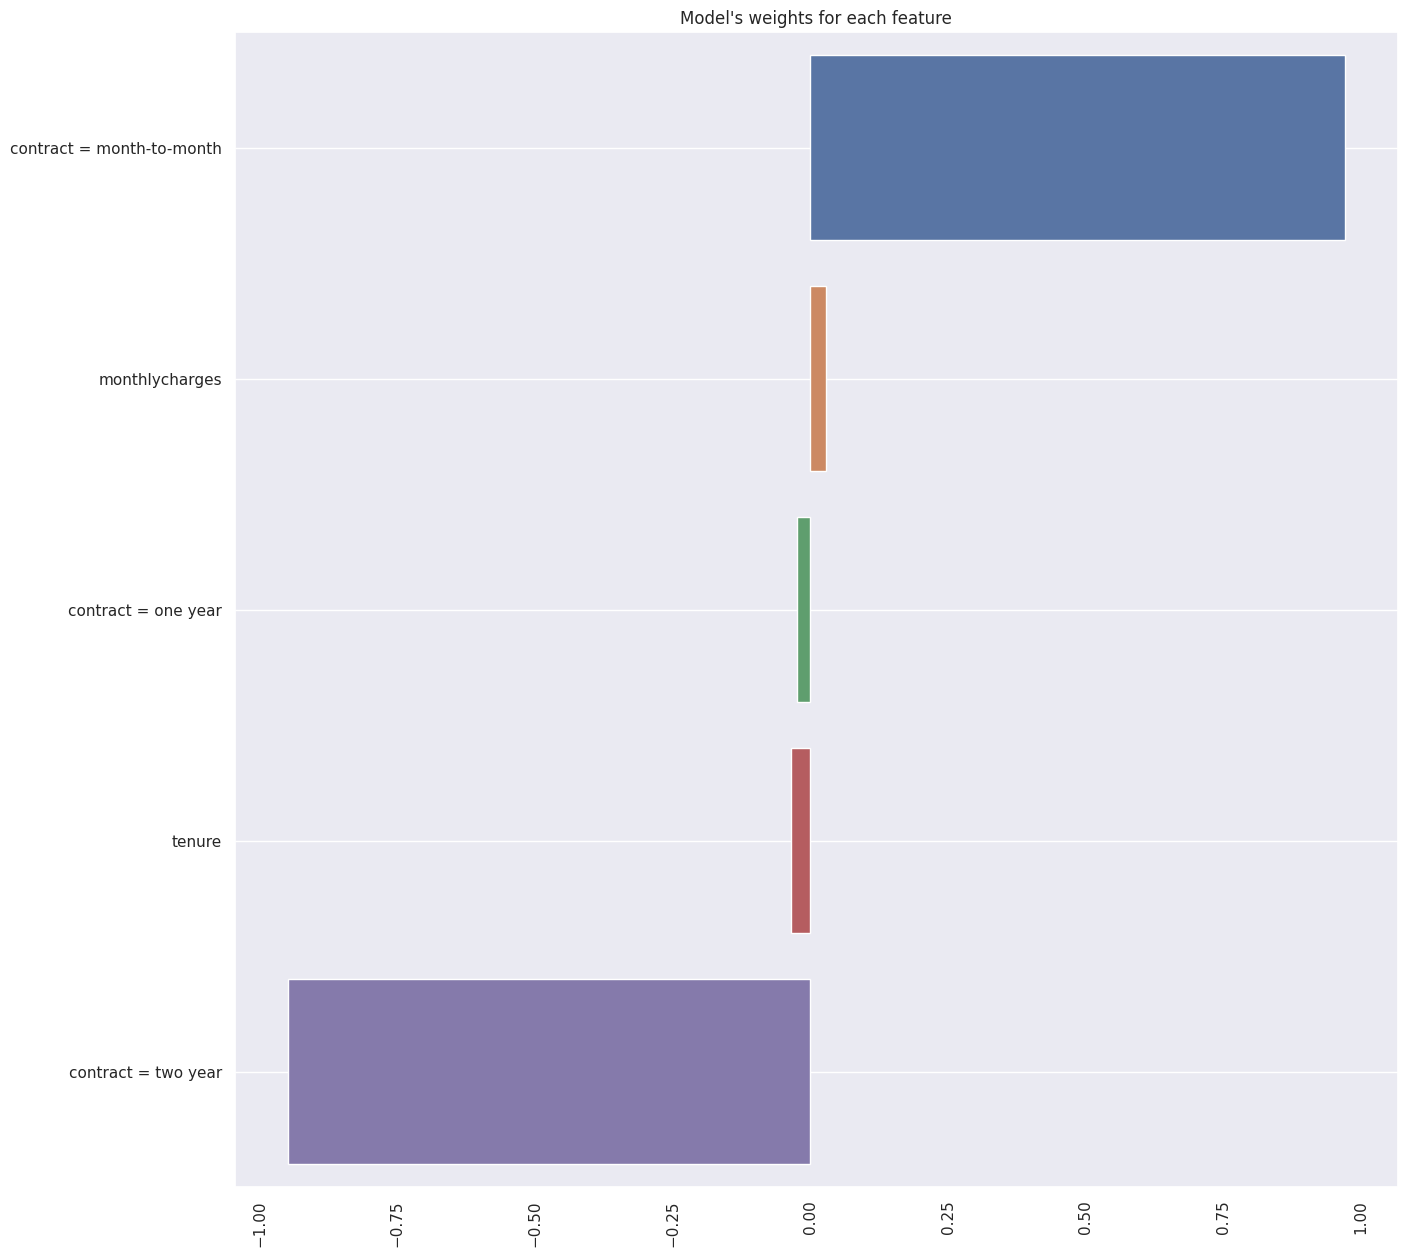

In [36]:
weights_small = pd.Series(dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0]))).sort_values(ascending=False)
weights_small.index = [x.replace('=',' = ') for x in list(weights_small.index)]

plt.figure(figsize=(15,15))
plt.title("Model's weights for each feature")
sns.barplot(y=weights_small.index, x=weights_small.values)
plt.xticks(rotation=90)
ax = plt.gca()
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(False) # Show the vertical gridlines
plt.show()

In [37]:
y_pred_small = model_small.predict_proba(X_val_small)[:,1]
churn_decision_small = (y_pred_small >= 0.5)
accuracy_score(y_val,churn_decision_small)

0.7963094393186657

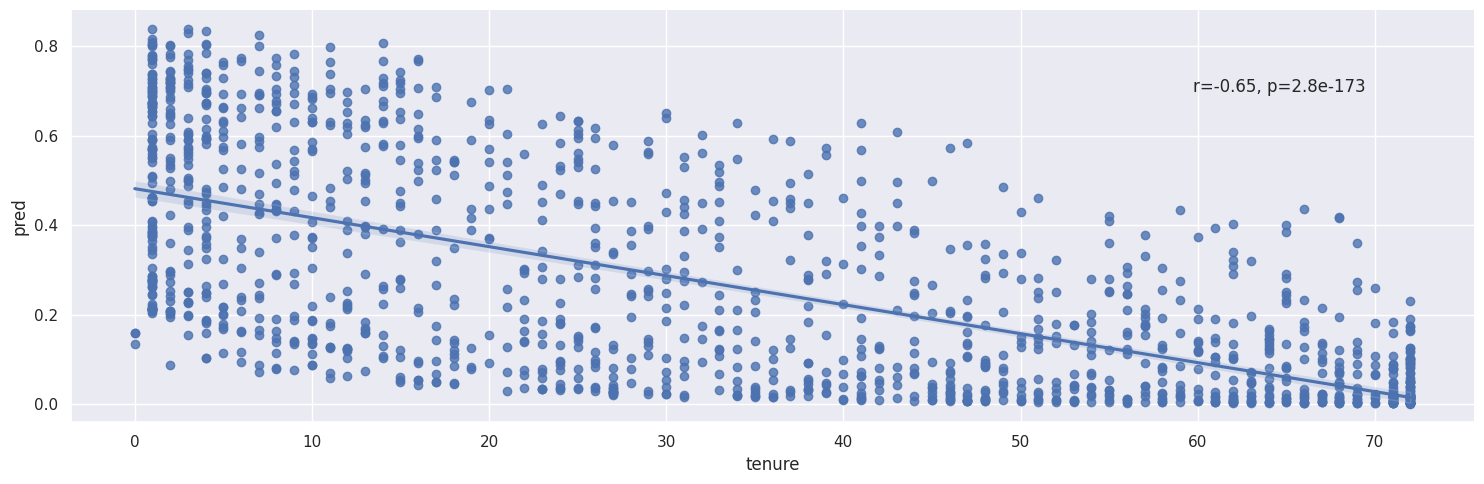

In [81]:
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(df_val.tenure.values, y_pred)
    ax = plt.gca()
    ax.text(.8, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

df_val_full = pd.concat([df_val,pd.Series(y_pred)], axis=1)
df_val_full.columns = list(df_val.columns) + ['pred']

g = sns.lmplot(data = df_val_full, x='tenure', y='pred', aspect=3)
g.map_dataframe(annotate)
plt.tight_layout()
plt.show()

## 7. Using the model

In [82]:
dicts_full_train = df_full_train[categorical+numerical].to_dict(orient='records')

dv_full = DictVectorizer(sparse=True)

X_full_train = dv.fit_transform(dicts_full_train)
y_full_train = df_full_train.churn.values

In [83]:
model = LogisticRegression().fit(X_full_train,y_full_train)

## 8. Summary